# Measuring Quality of a Convolutional Gridding Procedure

In this notebook, we discuss how a convolutional gridding procedure using the FFT may be evaluated in terms of its proximity to the result of a direct Fourier transform. The routines in `algorithms/core.py` which are useful for performing this analysis are described.

Suppose that we are given a (one-dimensional) convolutional gridding function $C(u)$ with support in the interval $[-W/2, W/2]$ for some integer $W$ and a gridding correction function $h(x)$ where $u$ and $x$ are scaled as described in the "Quick Start" notebook. For a set of visibilities $\mathcal{V}(u_i)$ and a collection of weights $w_i$ that sum to one, the DFT map is given by

$$ D_{\text{DFT}}(x) = \displaystyle\sum_i w_i\mathcal{V}(u_i)  \exp(\mathrm{i}2\pi u_ix)$$

This is to be approximated using an $N$ point FFT at the points $x_p=p/N$ for $p\in\{-N/2,...,N/2-1\}$ which is

$$ D_{\text{FFT}}(x_p) = h(x_p)\displaystyle\sum_{r=-N/2}^{N/2-1} G_r\exp\left(\mathrm{i}{2\pi r x_p}\right)$$

where the gridded visibilities $G_r$ are given by

$$G_r = \displaystyle\sum_i C(r-u_i)w_i{\mathcal{V}}(u_i)$$


Thus
$$D_{\text{DFT}}(x) - D_{\text{FFT}}(x) = \displaystyle\sum_i w_i\mathcal{V}(u_i)\exp(\mathrm{i}2\pi u_i x)
\left(1 - h(x)\displaystyle\sum_{|r-u_i|\leq W/2} C(r-u_i)\exp\left[\mathrm{i}2\pi (r-u_i) x\right]\right)
$$
where the sum over $r$ is over integer values satisfying $|r-u_i|\leq W/2$.

By the Cauchy-Schwarz inequality,
$$|D_{\text{DFT}}(x) - D_{\text{FFT}}(x)|^2 \leq \left(\displaystyle\sum_i w_i|\mathcal{V}(u_i)|^2\right)
\left(\displaystyle\sum_i w_i\left|1 - h(x)\displaystyle\sum_{|r-u_i|\leq W/2} C(r-u_i)\exp\left[\mathrm{i}2\pi (r-u_i) x\right]\right|^2\right)
$$

The second factor on the right hand side may be interpreted as a weighted mean, since the weights $w_i$ add up to one. If the visibility locations $u_i$ are uniformly distributed between the gridpoints of the transform, it may be replaced by an integral. The sum over $r$ involves $W$ terms, one for each of the points at which the visibility is gridded. There are several equivalent ways of performing the replacement, the one we have used in the code is

\begin{eqnarray}\displaystyle\sum_i w_i\left|1 - h(x)\displaystyle\sum_{|r-u_i|\leq W/2} C(r-u_i)\exp\left[\mathrm{i}2\pi (r-u_i) x\right]\right|^2 &\approx& \displaystyle\int_0^1\mathrm{d}\nu\, \left| 1 - h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\exp[i2\pi(r-\nu)x]\right|^2 \\
&=& 2\int_0^{1/2}\mathrm{d}\nu\, \left| 1 - h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\exp[i2\pi(r-\nu)x]\right|^2
\end{eqnarray}
where $C_r(\nu)\equiv C(r-\nu)$. If $W$ is even, the sum is over integer values of $r$, but if $W$ is odd, the values of $r$ are half-integers (i.e., half way between the integers). Notice that as $\nu$ ranges over $[0,1]$ and $r$ ranges over $-W/2+1$ through $W/2$, the difference $r-\nu$ takes on values between $-W/2$ and $W/2$ which is the support of $C$. The final change of limits of integration over $\nu$ is permissible if we assume that the convolutional gridding function $C$ is even.

We define the **map error** $\ell(x)$ by
$$ \ell(x) = \int_0^1\mathrm{d}\nu\, \left| 1 - h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\exp[i2\pi(r-\nu)x]\right|^2$$
although it is actually bounds the **square** of the difference between the DFT and FFT based maps once it has been multiplied by $\sum_i w_i|\mathcal{V}(u_i)|^2$. The map error is our primary metric for evaluating the choice of functions for gridding convolution $C(u)$ and correction $h(x)$. We also use the mean of the map error over a region of interest in the map as the basis for finding the least-misfit gridding functions which are optimized for use when retaining a the central portion of the FFT map:
$$E = \frac{1}{2x_0}\displaystyle\int_{-x_0}^{x_0} \ell(x)\,\mathrm{d}x $$

# Misfit analysis of a given convolutional gridding function

For definiteness, let us consider the family of prolate spheroidal functions proposed by Schwab in the VLA Scientific Memorandum 132 (1980).

$$C(u) = (1-\eta^2)^\alpha \psi_{\alpha,0}(c,\eta) = (1-\eta^2)^{\alpha/2} S_{\alpha,\alpha}(c,\eta)$$

where $\eta=2u/W$ and $c=\pi W/2$ for an integer $W$. The support of the convolution function is $[-W/2, W/2]$ so that a visibility is gridded into $W$ points in each direction, and $\alpha$ is a weighting function usually chosen in the range $0\leq\alpha\leq 2$. The function $S_{m,n}$ is the prolate spheroidal angular function of the first kind and is available in the `scipy.special` library as `pro_ang1`.

In [1]:
# Imports needed for notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from algorithms.core import make_evaluation_grids, gridder_to_grid_correction, calc_map_error

The routines `make_evaluation_grids`, `gridder_to_grid_correction` and `calc_map_error` are useful for performing the analysis. 

The routine `make_evaluation_grids` defines sets of points `nu` and `x` at which the gridding and grid correction functions respectively will be evaluated. Its input arguments are `W`, `M` and `N`. The convolutional gridding function has support $[-W/2, W/2]$, is assumed to be even and is evaluated on the vector `nu` which consists of $MW$ points $\nu_m=(m+0.5)/(2M)$ for $m=0,...,MW-1$ within the interval $[0, W/2]$. The gridding correction function is evaluated on the vector `x` which consists of $N+1$ points $x_n=n/(2N)$ for $n=0,...,N$ within the interval $[0,1/2]$.

In the code below, we place the values of the convolutional gridding function at the points in `nu` in the array `gridder` and pass this to the function `gridder_to_grid_correction`. It is straightforward to show from the integral defining $\ell(x)$ above that its value is minimized if the gridding correction is $h(x)$ chosen to be
$$ h(x) = \frac{\displaystyle\int_0^1 \mathrm{d}\nu\, \displaystyle\sum_r C_r(\nu)\cos[2\pi(r-\nu)x]}{\displaystyle\int_0^1 \mathrm{d}\nu\, \displaystyle\sum_{r_1}\sum_{r_2} C_{r_1}(\nu)C_{r_2}(\nu)\cos[2\pi(r_1-r_2)x]} $$

The function `gridder_to_grid_correction` has an argument `optimal` which evaluated this gridding correction function when it is set to `True`. On the other hand, the gridding correction function is often chosen to be the reciprocal of the Fourier transform of the convolutional gridding function, which corresponds to setting 
$$ h(x) = \frac{1}{\displaystyle\int_0^1 \mathrm{d}\nu\, \displaystyle\sum_r C_r(\nu)\cos[2\pi(r-\nu)x]}$$

This is the function evaluated when the `optimal` argument is set to `False`.

The function `calc_map_error` calculates $\ell(x)$ when given the gridding convolution and correction functions, provided they have been evaluated on the points specified by `make_evaluation_grids`. In the code below, it is evaluated for both choices of gridding correction function.

<IPython.core.display.Javascript object>


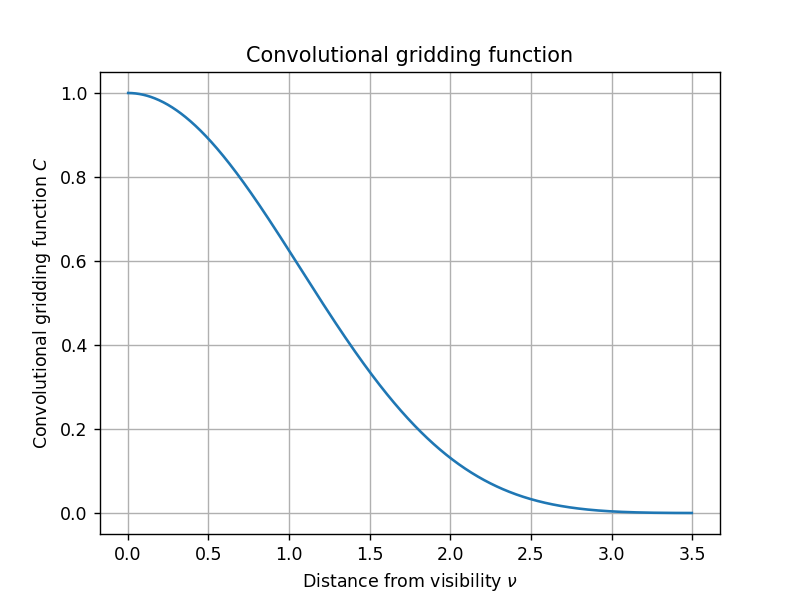

<IPython.core.display.Javascript object>


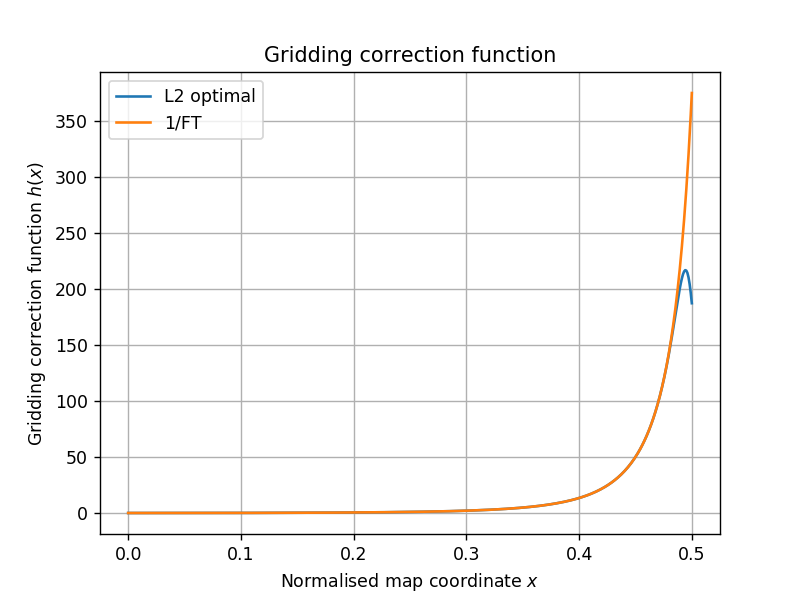

<IPython.core.display.Javascript object>


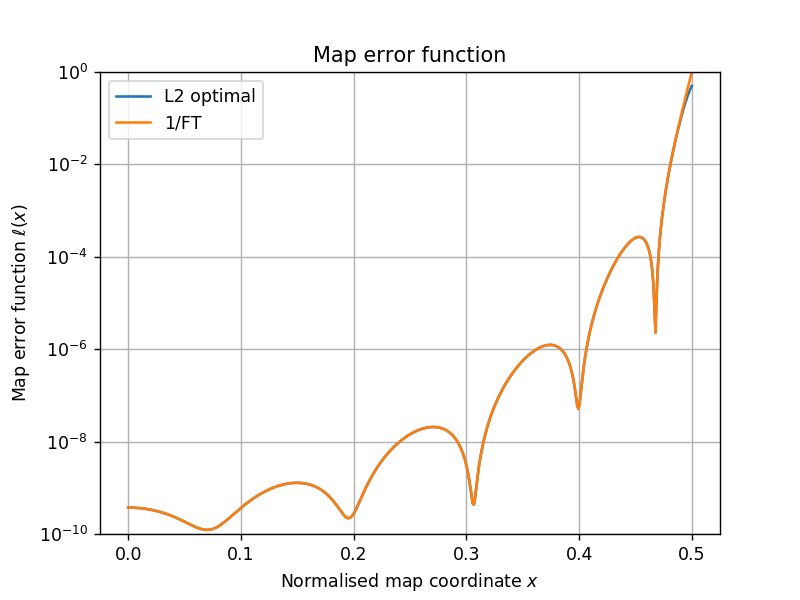

In [2]:
from scipy.special import pro_ang1
from algorithms.prolateSpheroidal import grdsf

alpha = 1
W = 7
M = 128
N = 512
nu, x = make_evaluation_grids(W, M, N)

# Calculate the convolutional gridding function at the points specified by nu
eta = 2*nu/W
gridder = (1-eta**2)**(alpha/2) * pro_ang1(alpha, alpha, np.pi*W/2, eta)[0]

# Evaluate the least-squares optimal gridding correction function
gc_opt = gridder_to_grid_correction(gridder, nu, x, W, optimal=True)
ell_opt = calc_map_error(gridder, gc_opt, nu, x, W)

# Evaluate the gridding correction function using reciprocal of Fourier transform
#  of convolution function
gc_ft = gridder_to_grid_correction(gridder, nu, x, W, optimal=False)
ell_ft = calc_map_error(gridder, gc_ft, nu, x, W)

# Plot the results

plt.figure()
plt.plot(nu, gridder)
plt.title('Convolutional gridding function')
plt.xlabel('Distance from visibility $\\nu$')
plt.ylabel('Convolutional gridding function $C$')
plt.grid(True)

plt.figure()
plt.plot(x, gc_opt, label='L2 optimal')
plt.plot(x, gc_ft, label='1/FT')
plt.title('Gridding correction function')
plt.xlabel('Normalised map coordinate $x$')
plt.ylabel('Gridding correction function $h(x)$')
plt.grid(True)
plt.legend()

plt.figure()
plt.semilogy(x, ell_opt, label='L2 optimal')
plt.semilogy(x, ell_ft, label='1/FT')
plt.ylim(1.0e-10, 1.0)
plt.title('Map error function')
plt.xlabel('Normalised map coordinate $x$')
plt.ylabel('Map error function $\\ell(x)$')
plt.grid(True)
plt.legend()

We see that the difference between the two choices of gridding correction function is important near the edge of the map but is generally small in the interior of the map.

In the following cell, we repeat the above analysis for a number of "conventional" convolutional gridding functions that have been proposed.

<IPython.core.display.Javascript object>


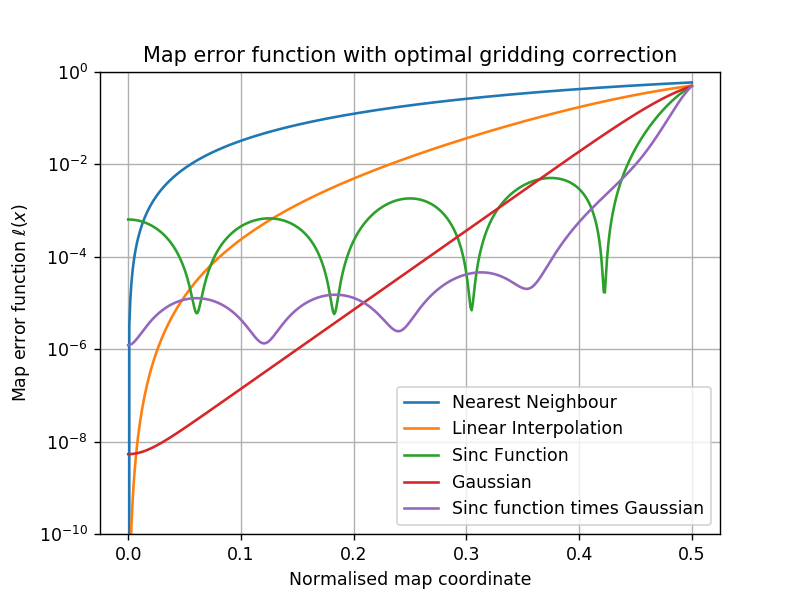

In [3]:
N = 512
M = 128

Wlist = [1, 2, 8, 8, 8]
names = ['Nearest Neighbour', 'Linear Interpolation', 'Sinc Function', 'Gaussian', 'Sinc function times Gaussian']

def func1(nu):
    return np.ones_like(nu)

def func2(nu):
    return 1-abs(nu)

def func3(nu):
    return np.sinc(nu)

def func4(nu):
    return np.exp(-nu**2)

def func5(nu):
    return np.exp(-(nu/2.52)**2)*np.sinc(nu/1.55)
    

plt.figure()    

funcs = [func1, func2, func3, func4, func5]
for W, name, func in zip(Wlist, names, funcs):    
    nu, x = make_evaluation_grids(W, M, N)
    gridder = func(nu)
    gc_opt = gridder_to_grid_correction(gridder, nu, x, W, optimal=True)
    ell_opt = calc_map_error(gridder, gc_opt, nu, x, W)
    plt.semilogy(x, ell_opt, label=name)

plt.title('Map error function with optimal gridding correction')
plt.xlabel('Normalised map coordinate')
plt.ylabel('Map error function $\\ell(x)$')
plt.ylim(1.0e-10, 1)
plt.grid(True)
plt.legend()

# Comments on analysis routines

In this section, we discuss various aspects of the code in the `algortihms` directory that has been used in this notebook. The contents of the file `algorithms/core.py` has been loaded into the last cell of this notebook for reference, but it may be easier to follow the discussion by opening it in a text editor.

In the routines `gridder_to_grid_correction` and `calc_map_error`, the function `gridder_to_C` is called first in order to reformat the convolutional gridding function evaluated at $MW$ points in the interval $(0,W/2)$ into a set of $W$ separate functions $C_r(\nu)$ each defined at $M$ points on the interval $\nu\in(0,1/2)$. These functions are stored in a two dimensional `numpy` array of shape $W\times M$. For many applications, it is more convenient to represent the convolutional gridding function as this collection of functions. For example, when gridding a visibility point, we only need to evaluate the $W$ functions at a single value of $\nu$ rather than the gridding function at $W$ separate values of its argument. In the code, this representation is referred to as `C` within the names of the functions. The values of $r$ for the $W$ functions start from 
$-W/2+1$ and increase in unit steps up to $W/2$.

The function `C_to_grid_correction` takes the functions $C_r(\nu)$ and computes the grid correction function $h(x)$ using the $L^2$ optimal expression or the reciprocal of the Fourier transform as discussed immediately preceeding the first example. The integrals of $\nu$ are replaced by means taken over the $M$ points $\nu_m=(m+0.5)/(2M)$ for $m=0,...,M-1$. This set of points is referred to as `nu_C` within the code, and they are the first $M$ points of the vector `nu` generated by `make_evaluation_grids`. The points $x$ at which the correction function is evaluated are given by the input argument `x`.

The function `calc_map_error_from_C` evaluates $\ell(x)$ from
$$\ell(x) = 2\int_0^{1/2}\mathrm{d}\nu\, \left| 1 - h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\exp[i2\pi(r-\nu)x]\right|^2$$
The integral is again replaced by a mean over the points in `nu_C`, and the real and imaginary components are treated separately before being squared and added together to give the map error.

In [4]:
# %load algorithms/core.py
from scipy.optimize import leastsq
from scipy.linalg import solve_triangular
import numpy as np
from attr import attrib, attrs
from typing import List


@attrs
class OptFunc:
    W = attrib(type=int)
    x0 = attrib(type=float)
    h = attrib(type=np.ndarray)
    M = attrib(type=int)


@attrs
class Lookup:
    W = attrib(type=int)
    Ms = attrib(type=int)
    table = attrib(type=List[np.ndarray])
    degree = attrib(type=int)


def trap(vec, dx):
    """Perform trapezoidal integration

    Args:
        vec (np.ndarray): Vector of equally-spaced samples of the integrand
        dx (float): Intersample separation

    Returns:
        Trapezoidal rule estimate of the integral
    """
    return dx * (np.sum(vec) - 0.5 * (vec[0] + vec[-1]))


def func_to_min(h, x0, M, W):
    """Function defining quantity to be minimized using least-squares algorithm

    The vector to be adjusted is the sampled grid correction function evaluated over the region of interest
    of the map. From this, sampled values of the gridding functions C are calculated and a loss is
    found based on the current correction and gridding functions.

    Args:
        h (np.ndarray): The vector of grid correction values sampled on [0,x0) to optimize
        x0 (float): The portion of the map (-x0 <= x <= x0) over which misfit is to be minimized
        M (int): 2*M is the number of points within each unit interval that the gridding function is sampled
        W (int): Defines support of gridding function -W/2 < nu <= W/2

    Returns:
        loss (np.ndarray): Vector whose sum of squares is the quantity to minimize
    """
    N = len(h)
    nu_C = (np.arange(M, dtype=float) + 0.5) / (2 * M)
    x = x0 * np.arange(N+1, dtype=float)/N
    C = calc_C(h, x0, nu_C, W)
    h_ext = np.concatenate(([1.0], h))
    loss = np.zeros((len(h_ext), 2, M), dtype=float)
    for n, x_val in enumerate(x):
        one_app = 0
        for r in range(0, W):
            ell = r - (W/2) + 1
            one_app += h_ext[n] * C[r, :] * np.exp(2j * np.pi * (ell - nu_C) * x_val)
        loss[n, 0, :] = 1.0 - np.real(one_app)
        loss[n, 1, :] = np.imag(one_app)
        if n in [0, N]:
            loss[n, :, :] /= np.sqrt(2)
    loss = loss.reshape(2 * M * (N + 1))
    return loss


def find_opt_func(W, x0, N, M, h_initial=None):
    """Calls the non-linear least-squares fitter to find the optimal grid correction function

    Args:
        W (int): Defines support of gridding function -W/2 < nu <= W/2
        x0 (float): The portion of the map (-x0 <= x <= x0) over which misfit is to be minimized
        N (int): Specifies number of points at which the grid correction function is evaluated over
            the interval (0, x0]
        M (int): 2*M is the number of points within each unit interval that the gridding function is sampled
        h_initial (np.ndarray): Initial guess at the grid correction function sampled on (0,x0]. If this
            is unspecified, a uniform initial guess is used

    Returns:
        An object of type OptFunc containing the results of the optimization
    """
    if h_initial is None:
        h_initial = np.ones(N, dtype=float)
    h = leastsq(func_to_min, h_initial, args=(x0, M, W), full_output=True)[0]
    return OptFunc(W, x0, h, M)


def make_evaluation_grids(W, M, N):
    """Generate vectors nu (visibility coordinate) and x (map coordinate) on which the gridding and
        gridding correction functions are to be sampled

        This is used to set up the optimization problem as well as for calculating the map error function

    Args:
        W (int): Defines support of gridding function -W/2 < nu <= W/2
        M (int): Determines the sampling of the nu grid, dnu = 1/(2*M)
        N (int): Determines the sampling of the x grid, dx = 1/(2*N)

    Returns:
        nu (np.ndarray): A set of W*M points on the interval (0, W*M/2) spaced 1/(2*M) apart, useful
            for plotting the gridding convolution function
        x (np.ndarray): A set of N points on the interval (0, 0.5) in map coordinates, useful for plotting
            the gridding correction function
    """
    nu = (np.arange(W * M, dtype=float) + 0.5) / (2 * M)
    x = np.arange(N+1, dtype=float)/(2 * N)
    return nu, x


def calc_C(h, x0, nu_C, W):
    """Calculate the least-square optimal gridding functions C[r_index, nu_index] given the
    sampled gridding correction function h.

    The gridding functions (referred to collectively as C) comprise a collection of W funtions
        (indexed by r which comes from the values [-W/2+1, ..., W/2]), and each is evaluated
        on the interval 0 < nu_C < 0.5. They are related to the usual convolutional gridding
        function by C(r - nu) = C_r(nu).

    We assume that h(0) = 1 for normalization, and this value is not stored in the array h.

    Args:
        h (np.ndarray): The vector of grid correction values sampled on (0,x0]
        x0 (float): The portion of the map (-x0 <= x <= x0) over which misfit is to be minimized
        nu_C (np.ndarray): The points in the interval (0,0.5) at which the W functions C_r are sampled
        W (int): Defines support of gridding function -W/2 < nu <= W/2

    Returns:
        C (np.ndarray): The W gridding functions sampled on nu_C. It is an array of size W x len(nu_C).
    """
    M = len(nu_C)
    C = np.zeros((W, M), dtype=float)
    N = len(h)
    B = np.zeros((2 * N + 2, W))
    x = x0 * np.arange(0, N+1, dtype=float)/N
    h_ext = np.concatenate(([1.0], h))
    rhs = np.r_[np.ones(N + 1, dtype=float), np.zeros(N + 1, dtype=float)]
    rhs[0] = rhs[0]/np.sqrt(2.0)
    rhs[N] = rhs[N]/np.sqrt(2.0)
    for m, nu_val in enumerate(nu_C):
        for r in range(W):
            k = r - (W/2) + 1
            B[:N+1, r] = h_ext * np.cos(2 * np.pi * (k - nu_val) * x)
            B[N+1:, r] = h_ext * np.sin(2 * np.pi * (k - nu_val) * x)
        B[0, :] = B[0, :]/np.sqrt(2.0)
        B[N, :] = B[N, :]/np.sqrt(2.0)
        B[N+1, :] = B[N+1, :]/np.sqrt(2.0)
        B[2*N+1, :] = B[2*N+1, :]/np.sqrt(2.0)
        q, r = np.linalg.qr(B)
        C[:, m] = solve_triangular(r, np.dot(q.transpose(), rhs))
        # C[:,m] = np.linalg.lstsq(B, rhs)[0]
    return C


def calc_gridder(h, x0, nu, W):
    """Starting from a sampled gridding correction function h, calculate the gridding function at the
    points nu on the interval (0,W/2). The grid nu on which the gridding function is defined should
    have been generated using make_evaluation_grids. This is a convenience function which allows the array
    of gridding functions generated by calc_C to be formatted as a single vector for ease of plotting and
    further calculations.

    Args:
        h (np.ndarray): The vector of grid correction values sampled on [0,x0)
        x0 (float): The portion of the map (-x0 <= x <= x0) over which misfit is to be minimized
        nu (np.ndarray): W*M points in the interval (0,W/2) at which the gridding function is required. Should
            be the result of calling make_evaluation_grids.
        W (int): Defines support of gridding function -W/2 < nu <= W/2

    Returns:
        gridder (np.ndarray): A vector of length len(nu) specifying the gridding function evaluated at nu
    """
    M = len(nu) // W
    return C_to_gridder(calc_C(h, x0, nu[:M], W))


def C_to_gridder(C):
    """Converts a collection of W gridding functions C into a single vector representing the conventional
    gridding function

    Args:
        C (np.ndarray): Array of size W x M specifying the W gridding functions sampled on M points in (0, 0.5).

    Returns:
        gridder (np.ndarray): The gridding function evaluated at W*M points in the interval (0, W/2)
    """
    W, M = C.shape
    gridder = np.zeros(M*W, dtype=float)
    for m in range(M):
        for rp in range(0, W):
            ellp = rp - (W/2) + 1
            indx = int(m - 2*ellp*M)
            if indx >= 0:
                gridder[indx] = C[rp, m]
            else:
                gridder[-indx-1] = C[rp, m]
    return gridder


def gridder_to_C(gridder, W):
    """Converts a conventional gridder function defined on W*M points in the interval (0, W/2)
    to a set of W gridding functions sampled on M points in (0,0.5). The collection of points nu
    at which gridder is sampled should have been generated using make_evaluation_grids.

    Args:
        gridder (np.ndarray): Vector of size W*M specifying the gridding convolution function sampled
            in the interval (0, W/2).
        W (int): Defines support of gridding function -W/2 < nu <= W/2

    Returns:
        C (np.ndarray): Array of size W x M specifying the W gridding functions sampled on M points in (0, 0.5).
    """
    M = len(gridder) // W
    C = np.zeros((W, M), dtype=float)
    for r in range(0, W):
        ell = r - (W/2) + 1
        indx = (np.arange(M) - 2 * M * ell).astype(int)
        # Use symmetry to deal with negative indices
        indx[indx < 0] = -indx[indx < 0] - 1
        C[r, :] = gridder[indx]
    return C


def C_to_grid_correction(C, nu_C, x, optimal=True):
    """Converts a collection of W gridding functions C sampled on the points nu_C uniformly spaced in (0, 0.5)
        to a gridding correction function evaluated at the map coordinates in the vector x.

    Args:
        C (np.ndarray): Array of size W x M specifying the W gridding functions sampled on M points in (0, 0.5).
        nu_C (np.ndarray): The points in the interval (0,0.5) at which the W functions C_r are sampled.
        x (np.ndarray): Points in the map at which the grid correction should be calculated. These values should
            lie between -0.5 and 0.5.
        optimal (boolean): True to find least-squares optimal grid correction or False for the reciprocal of
            the Fourier transform of the gridding convolution function.

    Returns:
        grid_correction (np.ndarray): The grid correction function evaluated at the points in x
    """
    W = len(C)
    c = np.zeros(x.shape, dtype=float)
    d = np.zeros(x.shape, dtype=float)
    for n, x_val in enumerate(x):
        for rp in range(0, W):
            ellp = rp - (W/2) + 1
            for r in range(0, W):
                ell = r - (W/2) + 1
                d[n] += np.mean(C[rp, :] * C[r, :] * np.cos(2 * np.pi * (ellp - ell) * x_val))
            c[n] += np.mean(C[rp, :] * np.cos(2 * np.pi * (ellp - nu_C) * x_val))
    return c/d if optimal else 1/c


def gridder_to_grid_correction(gridder, nu, x, W, optimal=True):
    """Calculate grid correction function from gridding convolution function

    Args:
        gridder (np.ndarray): Vector of length W*M specifying the gridding convolution function sampled uniformly in (0, W/2).
        nu (np.ndarray): Vector of length W*M specifying points at which gridder is sampled. Should have been generated using
            make_evaluation_grids.
        x (np.ndarray): Points in the map at which the grid correction should be calculated. These values should
            lie between -0.5 and 0.5.
        W (int): Defines support of gridding function -W/2 < nu <= W/2
        optimal (boolean): True to find least-squares optimal grid correction or False for the reciprocal of
            the Fourier transform of the gridding convolution function.

    Returns:
        grid_correction (np.ndarray): The grid correction function evaluated at the points in x
    """
    M = len(nu) // W
    C = gridder_to_C(gridder, W)
    return C_to_grid_correction(C, nu[:M], x, optimal)


def calc_map_error_from_C(C, grid_correction, nu_C, x, W):
    """Calculate the map error at map coordinates x for the specified gridder and grid correction functions. The
    gridder is specified as a set of W functions sampled on the interval (0, 0.5).

    The map error integral is computed by taking the mean over the values of C at the points in nu_C. The
    values of nu_C will usually be uniformly spaced in the interval (0, 0.5), but they can also be chosen to
    be drawn uniformly at random fron the interval to give a stochastic evaluation of the integral.

    Args:
        C (np.ndarray): Array of size W x M specifying the W gridding functions sampled on M points in (0, 0.5).
        grid_correction (np.ndarray): The grid correction function evaluated at the points in x
        nu_C (np.ndarray): The points in the interval (0,0.5) at which the W functions C_r are sampled.
        x (np.ndarray): Points in the map at which the grid correction should be calculated. These values should
            lie between -0.5 and 0.5.
        W (int): Defines support of gridding function -W/2 < nu <= W/2

    Returns:
        map_error (np.ndarray): The map error evaluated at the points specified in x
    """
    M = len(nu_C)
    loss = np.zeros((len(x), 2, M), dtype=float)
    for n, x_val in enumerate(x):
        one_app = 0
        for r in range(0, W):
            ell = r - (W/2) + 1
            one_app += grid_correction[n] * C[r, :] * np.exp(2j * np.pi * (ell - nu_C) * x_val)
        loss[n, 0, :] = 1.0 - np.real(one_app)
        loss[n, 1, :] = np.imag(one_app)
    map_error = np.zeros(len(x), dtype=float)
    for i in range(len(x)):
        map_error[i] = np.mean((loss[i, 0, :].flatten())**2 + (loss[i, 1, :].flatten())**2)
    return map_error


def calc_map_error(gridder, grid_correction, nu, x, W):
    """Calculate the map error at map coordinates x for the specified gridder and grid correction functions. The
    gridder as a convolution function on a set of M*W points nu equally spaced on the interval (0, M*W/2). The values
    of x and nu should be generated using make_evaluation_grids.

    Args:
        gridder (np.ndarray): Vector of length W*M specifying the gridding convolution function sampled uniformly in (0, W/2).
        grid_correction (np.ndarray): The grid correction function evaluated at the points in x
        nu (np.ndarray): The points in the interval (0,W/2) at which the gridder is sampled.
        x (np.ndarray): Points in the map at which the grid correction should be calculated.
        W (int): Defines support of gridding function -W/2 < nu <= W/2.

    Returns:
        map_error (np.ndarray): The map error evaluated at the points specified in x
    """
    M = len(nu) // W
    C = gridder_to_C(gridder, W)
    return calc_map_error_from_C(C, grid_correction, nu[:M], x, W)


def make_lookup_table(opt_func, Ms, degree):
    """Calculate the lookup table needed to evaluate the gridding function efficiently using polynomial
    interpolation of the specified degree. The lookup table stores Ms samples per unit interval of the
    gridding function. The size of the table is approximately W * (Ms/2 + degree + 1) * (degree + 1)
    floating point numbers to allow for Newton interpolation using forward differences.

    Args:
        opt_func (OptFunc): Object specifying the result of running an optimization to generate
            a least misfit gridding correction function (e.g. by using find_optfunc)
        Ms (int): Number of points per unit interval in visibility coordinate at which to tabulate
            the gridding function and its derivatives
        degree (int): Degree of interpolation to use. Zero indicates simple nearest-neighbor table lookup

    Returns:
        lookup (Lookup): Object containing lookup table for use with get_grid_weights
    """
    nu_s = np.arange(Ms//2 + degree + 1, dtype=float)/Ms
    C = calc_C(opt_func.h, opt_func.x0, nu_s, opt_func.W)
    table = [C]
    for d in range(degree):
        C = np.diff(C, 1)
        table.append(C)
    return Lookup(opt_func.W, Ms, table, degree)


def get_grid_weights(lookup, u):
    """Calculate the W weights which are used to carry out gridding of a visibility point with coordinate u.
    This is computed using polynomial interpolation into a lookup table.

    Args:
        lookup (Lookup): Object containing lookup table calculated using make_lookup_table
        u (float): Visibility coordinate

    Returns:
        locations (np.ndarray): Integer gridpoints to which the visibility point contributes. These consist
            of integers s such that -W/2 < s-u <= W/2
        weights (np.ndarray): Weights to multiply visibility by before adding to the gridpoints
    """
    locations = np.arange(int(np.floor(u - lookup.W/2)) + 1, int(np.floor(u + lookup.W/2) + 1))
    nu_C = (u - lookup.W/2) - np.floor(u - lookup.W/2)
    rev = (nu_C > 0.5)
    if rev:
        nu_C = 1.0 - nu_C
    loc = lookup.Ms * nu_C
    pt = int(np.floor(loc)) if lookup.degree > 0 else int(np.round(loc))
    ft = loc - pt
    # Perform polynomial interpolation
    weights = lookup.table[0][:, pt].copy()
    factor = 1
    for k in range(lookup.degree):
        factor *= (ft - k)/(k + 1)
        weights += lookup.table[k+1][:, pt]*factor
    if rev:
        weights = weights[::-1]
    return locations, weights


def get_gridder(lookup, nu):
    """Calculate the gridding convolution function C(nu) at -W/2<=nu<=W/2.
        Prefer get_grid_weights to this function for efficiency.

    Args:
        lookup (Lookup): Object containing lookup table calculated using make_lookup_table
        nu (float): Coordinate at which gridding convolution function is required

    Returns:
        result (float): Value of gridding convolution function
    """
    assert(-lookup.W/2 <= nu <= lookup.W/2)
    # Find place in look-up table at which to interpolate
    if np.remainder(lookup.W/2 - nu, 1.0) >= 0.5:
        nu = -nu
    r = lookup.W/2 - int(np.floor(lookup.W/2 - nu))
    loc = lookup.Ms * (r - nu)
    pt = int(np.floor(loc)) if lookup.degree > 0 else int(np.round(loc))
    ft = loc - pt
    # Perform polynomial interpolation
    ell = int(r + lookup.W/2 - 1)
    result = lookup.table[0][ell, pt]
    factor = 1
    for k in range(lookup.degree):
        factor *= (ft - k)/(k + 1)
        result += lookup.table[k + 1][ell, pt]*factor
    return float(result)


def get_grid_correction(opt_func, x, optimal=True):
    """Calculate the gridding correction function at a set points x in map coordinates.

    This will generally be called once for a given map size and the results saved for use.

    Args:
        opt_func (OptFunc): Object specifying the result of running an optimization to generate
            a least misfit gridding correction function (e.g. by using find_optfunc)
        x (np.ndarray): Map coordinates at which the grid correction is required
        optimal (boolean): True to find least-squares optimal grid correction or False for the reciprocal of
            the Fourier transform of the gridding convolution function.

    Returns:
        grid_correction (np.ndarray): The grid correction function evaluated at the points in x
    """
    nu_ref = (np.arange(opt_func.M) + 0.5) / (2*opt_func.M)
    C_ref = calc_C(opt_func.h, opt_func.x0, nu_ref, opt_func.W)
    return C_to_grid_correction(C_ref, nu_ref, x, optimal)
